## 6. Decision Trees and Ensemble Learning

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
#!wget $data

In [4]:
df = pd.read_csv('CreditScoring.csv')

In [5]:
df

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Status     4455 non-null   int64
 1   Seniority  4455 non-null   int64
 2   Home       4455 non-null   int64
 3   Time       4455 non-null   int64
 4   Age        4455 non-null   int64
 5   Marital    4455 non-null   int64
 6   Records    4455 non-null   int64
 7   Job        4455 non-null   int64
 8   Expenses   4455 non-null   int64
 9   Income     4455 non-null   int64
 10  Assets     4455 non-null   int64
 11  Debt       4455 non-null   int64
 12  Amount     4455 non-null   int64
 13  Price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


In [7]:
df.columns = df.columns.str.lower()

In [8]:
for c in df.columns:
    print(df[c].value_counts())

status
1    3200
2    1254
0       1
Name: count, dtype: int64
seniority
0     535
1     510
2     454
3     336
5     266
10    236
4     233
6     181
8     163
15    159
20    151
7     137
12    133
14    114
11    105
13     91
9      80
18     65
16     62
25     62
17     56
30     49
22     41
19     39
23     26
21     23
24     19
40     14
28     14
27     14
26     14
35     13
29     11
31     10
32     10
33      5
38      5
37      4
36      4
45      3
43      2
41      1
42      1
48      1
47      1
39      1
34      1
Name: count, dtype: int64
home
2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: count, dtype: int64
time
60    1933
36     942
48     860
24     350
12     148
18      93
30      49
6       33
42      29
54      17
72       1
Name: count, dtype: int64
age
28    178
26    163
32    159
30    156
34    155
31    153
27    153
24    152
36    145
37    144
25    143
33    141
40    139
38    135
29    131
23    128
39    126
35  

In [9]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [10]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df['status'] = df['status'].map(status_values)

In [11]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df['home'] = df['home'].map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df['marital'] = df['marital'].map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df['records'] = df['records'].map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df['job'] = df['job'].map(job_values)

In [12]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [14]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [15]:
df = df[df.status!='unk'].reset_index(drop=True)

#### split the data

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_full_train.reset_index(drop=True)
df_test = df_val.reset_index(drop=True)

In [19]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [20]:
del df_train['status']
del df_val['status']
del df_test['status']

## 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree
* Overfitting
* Controlling the size of a tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [22]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [23]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [26]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.9104040451478577

In [27]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

Retraining with different tree depth

In [28]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [29]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7662032905962834

In [30]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

function to visulaize tree and conditions

In [31]:
from sklearn.tree import export_text

In [32]:
print(export_text(dt))

|--- feature_25 <= 0.50
|   |--- feature_27 <= 6.50
|   |   |--- feature_1 <= 862.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  862.50
|   |   |   |--- class: 1
|   |--- feature_27 >  6.50
|   |   |--- feature_12 <= 103.50
|   |   |   |--- class: 1
|   |   |--- feature_12 >  103.50
|   |   |   |--- class: 0
|--- feature_25 >  0.50
|   |--- feature_16 <= 0.50
|   |   |--- feature_12 <= 74.50
|   |   |   |--- class: 0
|   |   |--- feature_12 >  74.50
|   |   |   |--- class: 0
|   |--- feature_16 >  0.50
|   |   |--- feature_2 <= 8750.00
|   |   |   |--- class: 1
|   |   |--- feature_2 >  8750.00
|   |   |   |--- class: 0



In [33]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## 6.5 Decision trees parameter tuning

* selecting max_depth
* selecting min_samples_leaf

In [34]:
for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.622
   2 -> 0.696
   3 -> 0.766
   4 -> 0.802
   5 -> 0.823
   6 -> 0.842
   7 -> 0.860
   8 -> 0.873
   9 -> 0.886
  10 -> 0.890
  15 -> 0.914
  20 -> 0.912
None -> 0.911


In [35]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [36]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [37]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.802  0.823  0.842
5                 0.802  0.824  0.844
10                0.802  0.822  0.843
15                0.803  0.823  0.842
20                0.802  0.821  0.836
100               0.791  0.804  0.814
200               0.782  0.793  0.800
500               0.704  0.704  0.704

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

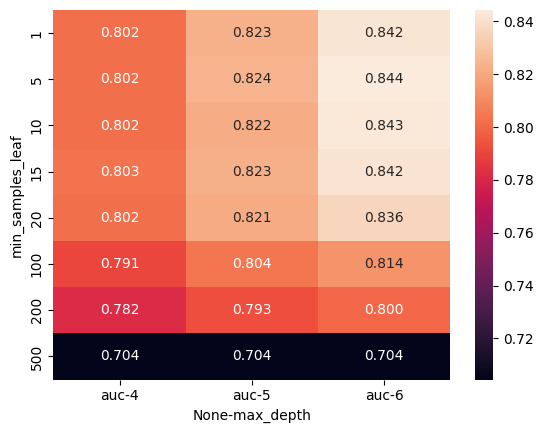

In [38]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [39]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf = RandomForestClassifier(n_estimators=n, )
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

NameError: name 'n' is not defined